In [1]:
# // p2112646
# Justin Wong Juin Hng
# DAAA/1B/04

import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.impute import SimpleImputer
import plotly.express as px
from IPython.core.display import display
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_rows', 200)

# Part A

Build a prediction model in order to predict which machine / component will possibly fail before it actually fails.
<br>




<br>

## (A) Data Cleaning

In [2]:
#Data Cleaning and Wrangling

df = pd.read_csv('../input/factory-data/factory_data (classification).csv')

display(df)


Unique ID Product ID Quality  Ambient T (C)  Process T (C)  \
0              1     K12965       M          24.95          35.45   
1              2     Z62710       L          25.05          35.55   
2              3     T20224       L          24.95          35.35   
3              4     Z33024       L          25.05          35.45   
4              5     Z52839       L          25.05          35.55   
...          ...        ...     ...            ...            ...   
19995      19996     T87335       M          25.75          35.35   
19996      19997     Z59525       H          25.85          35.35   
19997      19998     T83921       M          25.95            NaN   
19998      19999     K42424       H          25.95          35.65   
19999      20000     Z10048       M          25.95          35.65   

       Rotation Speed (rpm)  Torque (Nm)  Tool Wear (min)  Machine Status  
0                    1551.0         42.8                0               0  
1                    1408.0         46.3                3               0  
2                    1498.0         49.4                5               0  
3                    1433.0         39.5                7               0  
4                    1408.0         40.0                9               0  
...                     ...          ...              ...             ...  
19995                   NaN         29.5               14               0  
19996                1632.0         31.8               17               0  
19997                   NaN         33.4               22               0  
19998                1408.0         48.5               25               0  
19999                1500.0         40.2               30               0  

[20000 rows x 9 columns]

#### (A1) Drop Useless Rows
<br>

> Drop columns `Unique ID`  because these features are *not* considered relevant to the model and the prediction
of failure of component
> 
> Drop rows with `0` value to ensure reliability of data (does not interfere with mean calculation)
>
> Sort by *quality of product* to ensure that filling of empty values will have *correlation* to final quality of product
> **then** sort by machine status

<br>



In [3]:

df = df.drop(['Unique ID'],axis=1)
df = df.sort_values(by=['Machine Status'],ascending=True)

#drop rows with 0 in value
df.rename(columns = {'Tool Wear (min)':'Tool Lifespan (min)'}, inplace = True)
df = df.loc[(df[['Ambient T (C)', 'Process T (C)','Rotation Speed (rpm)','Torque (Nm)','Tool Lifespan (min)']] != 0).all(axis=1)]
print(df.describe())

       Ambient T (C)  Process T (C)  Rotation Speed (rpm)   Torque (Nm)  \
count   19760.000000   19363.000000          18586.000000  19760.000000   
mean       26.905516      36.904764           1538.948725     39.978715   
std         2.000687       1.483577            179.020043      9.977275   
min        22.150000      32.550000           1168.000000      3.800000   
25%        25.250000      35.750000           1423.000000     33.200000   
50%        26.950000      36.950000           1503.000000     40.100000   
75%        28.450000      37.950000           1612.000000     46.800000   
max        31.450000      40.750000           2886.000000     76.600000   

       Tool Lifespan (min)  Machine Status  
count         19760.000000    19760.000000  
mean            109.262146        0.034008  
std              62.909417        0.181255  
min               2.000000        0.000000  
25%              55.000000        0.000000  
50%             109.000000        0.000000  
75%      

#### (A2) Split Data & Feature Engineering
> Creating new features to enhance accuracy of model and increase relevance of data.





In [4]:


# Change name of product ID to LEFT(1) Product Code
df['Product ID'] = df['Product ID'].astype(str).str[0]
df = df.rename(columns={'Product ID':'Product Code'})


In [5]:
# Add the 3 features
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

dfs = [train, test]

for dataframe in dfs:
    dataframe['T Difference Squared (C^2)'] = (dataframe['Ambient T (C)']- dataframe['Process T (C)'])**2
    dataframe['Tool Lifespan/Temp Increase^2 (min/C^2)'] = round(dataframe['Tool Lifespan (min)'] /dataframe['T Difference Squared (C^2)'])
    dataframe['Horsepower (HP)'] = (dataframe['Rotation Speed (rpm)'] * dataframe['Torque (Nm)']) /5252



train = train.reset_index()
train = train.drop(['index'],axis=1)

test = test.reset_index()
test = test.drop(['index'],axis=1)


display(train)
display(test)

# display(cleaned_df)

Product Code Quality  Ambient T (C)  Process T (C)  \
0                S       L          26.95          38.05   
1                K       M          29.45          38.45   
2                K       L          26.85          36.95   
3                K       H          26.35          35.55   
4                Z       L          24.35          35.55   
...            ...     ...            ...            ...   
15803            K       L          24.95          36.05   
15804            K     NaN          25.55          36.15   
15805            K       M          30.95          40.35   
15806            Z       H          30.65          39.35   
15807            S       M          24.35          35.45   

       Rotation Speed (rpm)  Torque (Nm)  Tool Lifespan (min)  Machine Status  \
0                    1425.0         47.8                  179               0   
1                    1481.0         41.1                  215               0   
2                    1447.0         45.9                  162               0   
3                    1542.0         41.8                  166               0   
4                    1459.0         41.3                  196               0   
...                     ...          ...                  ...             ...   
15803                1820.0         23.6                  120               0   
15804                1311.0         46.6                   44               0   
15805                1428.0         39.9                   88               0   
15806                1525.0         38.0                  209               0   
15807                1842.0         27.0                  133               0   

       T Difference Squared (C^2)  Tool Lifespan/Temp Increase^2 (min/C^2)  \
0                          123.21                                      1.0   
1                           81.00                                      3.0   
2                          102.01                                      2.0   
3                           84.64                                      2.0   
4                          125.44                                      2.0   
...                           ...                                      ...   
15803                      123.21                                      1.0   
15804                      112.36                                      0.0   
15805                       88.36                                      1.0   
15806                       75.69                                      3.0   
15807                      123.21                                      1.0   

       Horsepower (HP)  
0            12.969345  
1            11.589699  
2            12.646097  
3            12.272582  
4            11.473096  
...                ...  
15803         8.178218  
15804        11.632254  
15805        10.848667  
15806        11.033892  
15807         9.469535  

[15808 rows x 11 columns]

Product Code Quality  Ambient T (C)  Process T (C)  Rotation Speed (rpm)  \
0               Z     NaN          24.35          34.85                2033.0   
1               S       L          23.85          34.95                   NaN   
2               T       L          22.75          33.45                1568.0   
3               T     NaN          29.45          37.25                1523.0   
4               K       L          24.35          35.35                1588.0   
...           ...     ...            ...            ...                   ...   
3947            Z       M          24.55          35.75                1683.0   
3948            Z       M          29.45          37.35                1542.0   
3949            T       L          30.45          39.25                1388.0   
3950            Z     NaN          30.55          39.75                1532.0   
3951            Z       M          27.65          37.95                1418.0   

      Torque (Nm)  Tool Lifespan (min)  Machine Status  \
0            16.7                  128               0   
1            52.5                  213               1   
2            35.1                  111               0   
3            36.0                   72               0   
4            32.5                  207               0   
...           ...                  ...             ...   
3947         31.6                   79               0   
3948         39.9                  184               0   
3949         41.9                  221               0   
3950         41.3                   32               0   
3951         49.3                  106               0   

      T Difference Squared (C^2)  Tool Lifespan/Temp Increase^2 (min/C^2)  \
0                         110.25                                      1.0   
1                         123.21                                      2.0   
2                         114.49                                      1.0   
3                          60.84                                      1.0   
4                         121.00                                      2.0   
...                          ...                                      ...   
3947                      125.44                                      1.0   
3948                       62.41                                      3.0   
3949                       77.44                                      3.0   
3950                       84.64                                      0.0   
3951                      106.09                                      1.0   

      Horsepower (HP)  
0            6.464414  
1                 NaN  
2           10.479208  
3           10.439452  
4            9.826733  
...               ...  
3947        10.126200  
3948        11.714737  
3949        11.073343  
3950        12.047144  
3951        13.310625  

[3952 rows x 11 columns]

#### (A3) Imputing Data
> Impute Categorical Data with `most_frequent`
>
> Imputing Numerical Data with using different methods found in scikit library
>
> Methods:
> 1. Mean Imputation
> 2. Median Imputation
> 3. kNN Imputation
> 4. Iterative Imputation

<br>

In [6]:
display(train.isnull().sum())

#take out the quality column because it is categorical data and needs to be imputed separately (train)
categorical_df = train[['Quality','Product Code','Machine Status']]
categorical_df = categorical_df.reset_index().drop('index',axis=1)

#drop the quality column to ensure no errors during imputation (train)
numerical_df = train.drop(['Quality','Product Code','Machine Status'],axis=1)

#take out the quality column because it is categorical data and needs to be imputed separately (test)
categorical_df_test = test[['Quality','Product Code','Machine Status']]
categorical_df_test = categorical_df_test.reset_index().drop('index',axis=1)

#drop the quality column to ensure no errors during imputation (test)
numerical_df_test = test.drop(['Quality','Product Code','Machine Status'],axis=1)


Product Code                                 0
Quality                                    785
Ambient T (C)                                0
Process T (C)                              331
Rotation Speed (rpm)                       940
Torque (Nm)                                  0
Tool Lifespan (min)                          0
Machine Status                               0
T Difference Squared (C^2)                 331
Tool Lifespan/Temp Increase^2 (min/C^2)    331
Horsepower (HP)                            940
dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

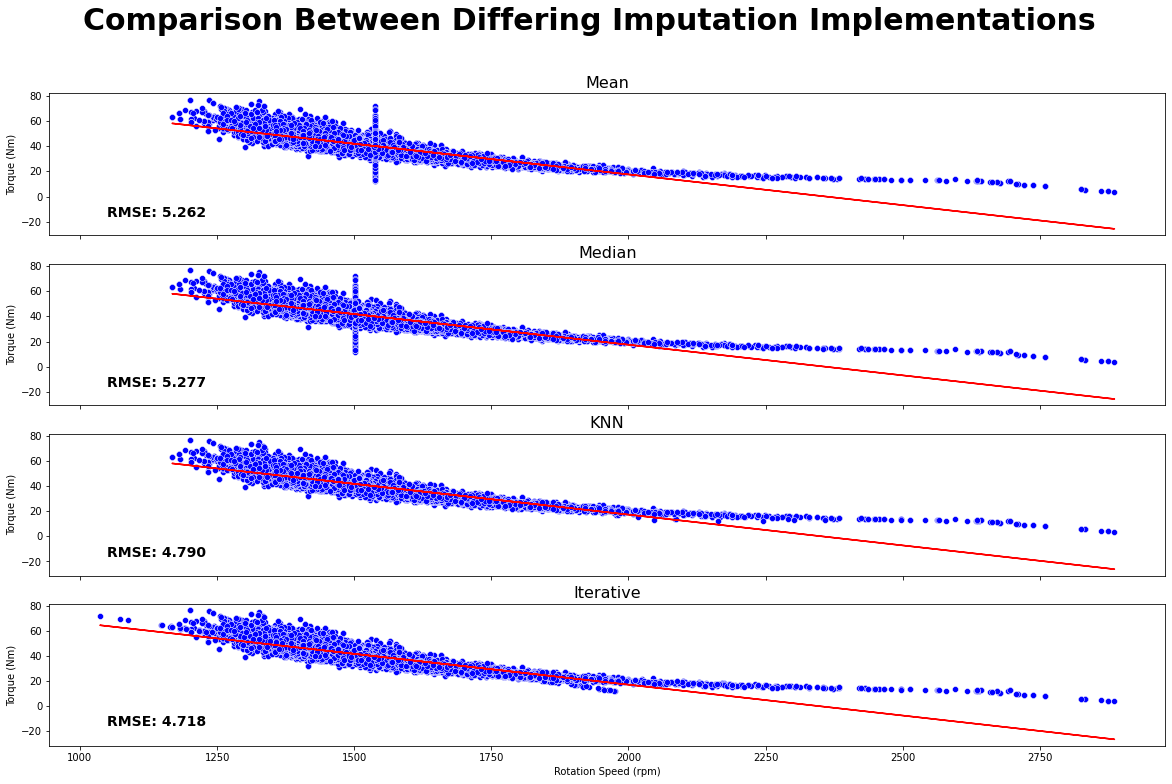

In [7]:
# imputer class
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

#impute categorical data using SimpleImputer (train)
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))
cat_columns = categorical_df.columns
categorical_df = pd.DataFrame(cat_pipe.fit_transform(categorical_df),columns=cat_columns)

# Mean Imputation for Numerical Data
mean_imputer = SimpleImputer(strategy='mean')
mean_imputed = mean_imputer.fit_transform(numerical_df)
mean = pd.DataFrame(mean_imputed, columns=numerical_df.columns)

# Median Imputation for Numerical Data
median_imputer = SimpleImputer(strategy='median')
median_imputed = median_imputer.fit_transform(numerical_df)
median = pd.DataFrame(median_imputed, columns=numerical_df.columns)

# KNN Imputation for Numerical Data
knn_imputer = KNNImputer(n_neighbors=7,weights='uniform')
knn_imputed = knn_imputer.fit_transform(numerical_df)
knn = pd.DataFrame(knn_imputed, columns=numerical_df.columns)

# Iterative Imputation for Numerical Data
iter_imputer = IterativeImputer(random_state=42)
iter_imputed = iter_imputer.fit_transform(numerical_df)
iterated = pd.DataFrame(iter_imputed, columns=numerical_df.columns)

# Comparison between different imputations
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20, 12))
fig.suptitle('Comparison Between Differing Imputation Implementations', fontsize=30,fontweight='bold')
axes = np.reshape(axes, -1)

data1 = [mean, median,knn, iterated]
titles = ['Mean', 'Median','KNN', 'Iterative']

for i, numerical_df in enumerate(data1):
    # Plotting the data
    x = numerical_df['Rotation Speed (rpm)']
    y = numerical_df['Torque (Nm)']
    sns.scatterplot(x, y, ax=axes[i], color='blue')

    # add linear regression line
    m, b = np.polyfit(x, y, 1)
    fit = m*x + b
    axes[i].plot(x, fit, color='red')

    # Setting the titles and including the Root Mean Square values
    axes[i].set_title(titles[i], fontsize=16)
    rmse = "{:.3f}".format(round(mean_squared_error(y, fit, squared=False), 3))
    axes[i].text(1050, -16 ,f'RMSE: {rmse}', fontsize=14, fontweight='bold')

#iterative imputation used as it has the lowest rsme value (train)
num_columns = numerical_df.columns
num_pipe = make_pipeline(RobustScaler(), IterativeImputer(random_state=42))
numerical_df = pd.DataFrame(num_pipe.fit_transform(numerical_df),columns=num_columns)


#impute categorical data using SimpleImputer (test)
cat_pipe_test = make_pipeline(SimpleImputer(strategy='most_frequent'))
cat_columns_test = categorical_df_test.columns
categorical_df_test = pd.DataFrame(cat_pipe_test.fit_transform(categorical_df_test),columns=cat_columns)

#iterative imputation used as it has the lowest rsme value (train)
num_columns_test = numerical_df_test.columns
num_pipe_test = make_pipeline(RobustScaler(), IterativeImputer(random_state=42))
numerical_df_test = pd.DataFrame(num_pipe_test.fit_transform(numerical_df_test),columns=num_columns)



#### (A4) Choice of Impute Method:
> **Iterative Implementation** as it has the *lowest* RSME Value
>
> We can see that the RSME Score for Iterative Imputation is 4.726, while the mean RSME Score for the other 3 are 5.12
>
> This suggests that the Iterative Imputation is the most effective form of imputation.

Additionally, when we look at the scatter plot of data, mean and median Imputation creates a vertical line of similar values that emphasises the fact that all imputed values are equal to the mean.

This reduces the variance of the imputed variable because none of the imputed values contribute to the variances. Thus the variance of the mean-imputed variable is always smaller than the variance of the original variable.

On top of that, mean imputation shrinks standard errors and confidence intervals, which leads to the distortion of relationships between variables, in this case, RPM and Torque.


#### (A5) Dataframe Stitching

In [8]:
# Stitch the dataframes together into one (train)
cleaned_df = pd.merge(numerical_df, categorical_df, left_index=True, right_index=True)
cleaned_df = cleaned_df.reset_index()
cleaned_df = cleaned_df.drop(['index'],axis=1)

# Stitch the dataframes together into one (test)
cleaned_df_test = pd.merge(numerical_df_test, categorical_df_test, left_index=True, right_index=True)
cleaned_df_test = cleaned_df_test.reset_index()
cleaned_df_test = cleaned_df_test.drop(['index'],axis=1)

#encode data (train)
le = preprocessing.LabelEncoder()
cleaned_df['Quality'] = le.fit(np.unique(cleaned_df['Quality'])).transform(cleaned_df['Quality'])
cleaned_df['Product Code'] = le.fit(np.unique(cleaned_df['Product Code'])).transform(cleaned_df['Product Code'])
cleaned_df['Machine Status'] = cleaned_df['Machine Status'].astype('int32')
cleaned_df = cleaned_df.iloc[:, [8,9,0,1,5,4,6,2,3,7,10]]


#encode data (test)
le = preprocessing.LabelEncoder()
cleaned_df_test['Quality'] = le.fit(np.unique(cleaned_df_test['Quality'])).transform(cleaned_df_test['Quality'])
cleaned_df_test['Product Code'] = le.fit(np.unique(cleaned_df_test['Product Code'])).transform(cleaned_df_test['Product Code'])
cleaned_df_test['Machine Status'] = cleaned_df_test['Machine Status'].astype('int32')
cleaned_df_test = cleaned_df_test.iloc[:, [8,9,0,1,5,4,6,2,3,7,10]]


#### (A6) Oversampling Data
> Oversample data to compensate for an imbalance that is either already present in the data, or likely to develop if a purely random sample were taken.

Additionally, we oversample the data to ensure a fair comparison amongst the training and testing data, as there is a 30:1 difference in the number of available training and testing data. This will result in the training and testing being skewed towards encouraging more predictions to be working than broken.

We oversample the data using `SMOTENC`, a tool generate synthetic data to oversample a minority target class in an imbalanced dataset.

In [9]:
from imblearn.over_sampling import SMOTENC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import Counter


#oversample for train
X = np.transpose(np.array
    (
    [
        cleaned_df['Quality'],
        cleaned_df['Product Code'],
        cleaned_df['Process T (C)'],
        cleaned_df['Ambient T (C)'],
        cleaned_df['T Difference Squared (C^2)'],
        cleaned_df['Tool Lifespan (min)'],
        cleaned_df['Tool Lifespan/Temp Increase^2 (min/C^2)'],
        cleaned_df['Rotation Speed (rpm)'],
        cleaned_df['Torque (Nm)'],
        cleaned_df['Horsepower (HP)']
    ]
    ))
y = np.transpose(np.array(cleaned_df['Machine Status']))


sm = SMOTENC(random_state=4, categorical_features=[0,1])
X_res, y_res = sm.fit_resample(X, y)
y_res = np.transpose(np.array([y_res]))
oversampled = np.hstack((X_res,y_res))
cleaned_df = pd.DataFrame(oversampled, columns = cleaned_df.columns)
display(cleaned_df)


#oversample for test
X = np.transpose(np.array
    (
    [
        cleaned_df_test['Quality'],
        cleaned_df_test['Product Code'],
        cleaned_df_test['Process T (C)'],
        cleaned_df_test['Ambient T (C)'],
        cleaned_df_test['T Difference Squared (C^2)'],
        cleaned_df_test['Tool Lifespan (min)'],
        cleaned_df_test['Tool Lifespan/Temp Increase^2 (min/C^2)'],
        cleaned_df_test['Rotation Speed (rpm)'],
        cleaned_df_test['Torque (Nm)'],
        cleaned_df_test['Horsepower (HP)']
    ]
    ))
y = np.transpose(np.array(cleaned_df_test['Machine Status']))
sm = SMOTENC(random_state=4, categorical_features=[0,1])
X_res, y_res = sm.fit_resample(X, y)
y_res = np.transpose(np.array([y_res]))
oversampled = np.hstack((X_res,y_res))
cleaned_df_test = pd.DataFrame(oversampled, columns = cleaned_df_test.columns)
display(cleaned_df_test)


Quality  Product Code  Ambient T (C)  Process T (C)  \
0          1.0           1.0       0.500000       0.000000   
1          2.0           0.0       0.681818       0.781250   
2          1.0           0.0       0.000000      -0.031250   
3          0.0           0.0      -0.636364      -0.187500   
4          1.0           3.0      -0.636364      -0.812500   
...        ...           ...            ...            ...   
30539      2.0           3.0       0.774053       0.688411   
30540      1.0           3.0       0.277413       0.579895   
30541      1.0           0.0       0.363636       0.713827   
30542      1.0           3.0      -0.738293      -0.816288   
30543      2.0           1.0       0.278903       0.629246   

       T Difference Squared (C^2)  Tool Lifespan (min)  \
0                        0.779703             0.638889   
1                       -0.526300             0.972222   
2                        0.123762             0.481481   
3                       -0.413676             0.518519   
4                        0.848700             0.796296   
...                           ...                  ...   
30539                   -0.240099             0.083333   
30540                   -0.654646            -0.603569   
30541                   -0.788695             0.378107   
30542                    0.703110             1.009539   
30543                   -0.744121             0.929700   

       Tool Lifespan/Temp Increase^2 (min/C^2)  Rotation Speed (rpm)  \
0                                          0.0             -0.412698   
1                                          2.0             -0.116402   
2                                          1.0             -0.296296   
3                                          1.0              0.206349   
4                                          1.0             -0.232804   
...                                        ...                   ...   
30539                                      0.0             -0.740741   
30540                                      0.0             -0.718812   
30541                                      1.0             -0.791477   
30542                                      1.0             -0.691677   
30543                                      2.0             -0.680585   

       Torque (Nm)  Horsepower (HP)  Machine Status  
0         0.574627         0.598403             0.0  
1         0.074627         0.070277             0.0  
2         0.432836         0.474664             0.0  
3         0.126866         0.331683             0.0  
4         0.089552         0.025641             0.0  
...            ...              ...             ...  
30539     1.037313         0.998329             1.0  
30540     0.680412         0.537661             1.0  
30541     0.455990         0.192360             1.0  
30542     0.802580         0.720662             1.0  
30543     0.477897         0.292012             1.0  

[30544 rows x 11 columns]

Quality  Product Code  Ambient T (C)  Process T (C)  \
0         1.0           3.0      -0.977273      -0.838710   
1         1.0           1.0      -0.931818      -1.000000   
2         1.0           2.0      -1.613636      -1.354839   
3         1.0           2.0       0.113636       0.806452   
4         1.0           0.0      -0.750000      -0.838710   
...       ...           ...            ...            ...   
7627      1.0           0.0       0.246083       0.583820   
7628      1.0           3.0       0.540166       0.703672   
7629      1.0           2.0       0.265258      -0.193503   
7630      1.0           1.0       0.265991       0.814446   
7631      1.0           1.0       0.202236       0.836235   

      T Difference Squared (C^2)  Tool Lifespan (min)  \
0                       0.354680             0.183486   
1                       0.730223             0.963303   
2                       0.477543             0.027523   
3                      -1.077079            -0.330275   
4                       0.666184             0.908257   
...                          ...                  ...   
7627                   -0.601159             1.020833   
7628                   -0.461071             0.643644   
7629                    0.817215             0.914390   
7630                   -0.933947             0.289254   
7631                   -1.027732            -0.283234   

      Tool Lifespan/Temp Increase^2 (min/C^2)  Rotation Speed (rpm)  \
0                                     0.00000              2.711340   
1                                     1.00000             -0.849112   
2                                     0.00000              0.314433   
3                                     0.00000              0.082474   
4                                     1.00000              0.417526   
...                                       ...                   ...   
7627                                  1.81846              1.193308   
7628                                  1.00000             -0.420016   
7629                                  1.00000             -1.378599   
7630                                  1.00000             -0.646747   
7631                                  0.00000             -0.746765   

      Torque (Nm)  Horsepower (HP)  Machine Status  
0       -1.633803        -1.827387             0.0  
1        0.887324         0.894406             1.0  
2       -0.338028        -0.338319             0.0  
3       -0.274648        -0.353064             0.0  
4       -0.521127        -0.580319             0.0  
...           ...              ...             ...  
7627    -0.758505        -0.660266             1.0  
7628     1.355346         1.731346             1.0  
7629     1.670344         1.381885             1.0  
7630     0.401860         0.218419             1.0  
7631     1.913150         2.225884             1.0  

[7632 rows x 11 columns]



#### (A6) All Features
1. Product Code
    >*Product Code*

2. Quality
    >*Quality*


3. Ambient Temperature$\ (\degree C) $
    >*Ambient T*


4. Process Temperature$\ (\degree C) $
    >*Process T*


5. Temperature Difference Squared$\ (\degree C^2)$
    >*T Difference Squared (C^2)*


6. Tool Lifespan$\ (min)$
    >*Tool Lifespan*

7. Tool Lifespan per Temp Increase Squared$\ (min/ \degree C^2) $
    >*Tool Lifespan/Temp Increase^2*


8. Rotation Speed$\ (rpm) $
    >*Rotation Speed*


9. Torque$\ (Nm) $
    >*Torque*


10. Horsepower$\ (hp) $
    >*Horsepower*


11. Machine Status
    >*Machine Status*

## (B) Exploratory Data Analysis

### (B1) Qualitative Variables

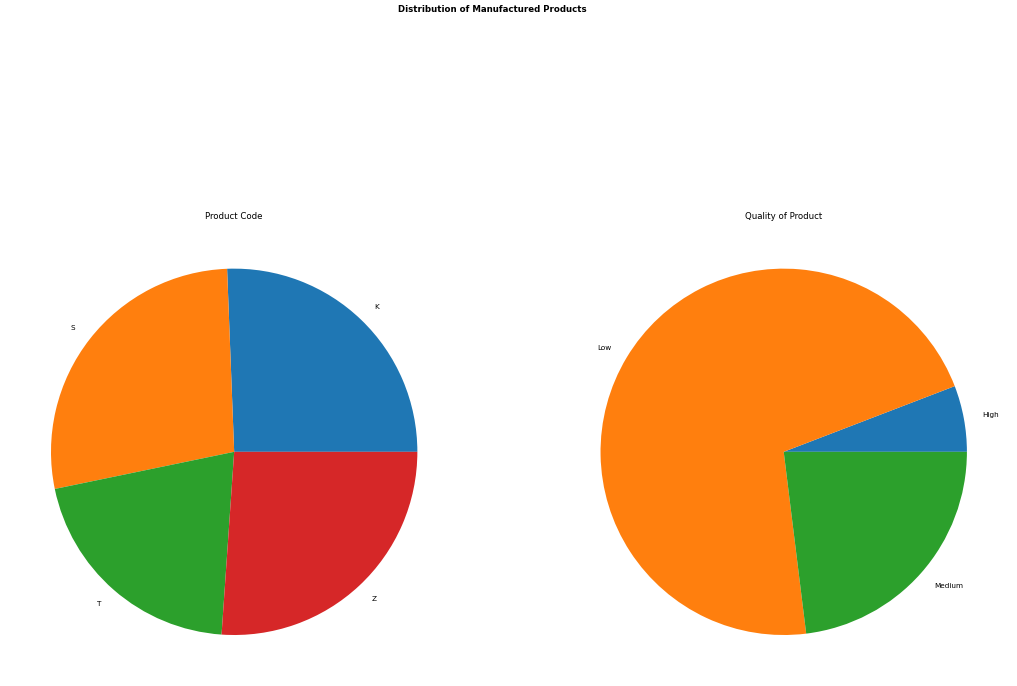

In [10]:
pie_arr = {}

for code in np.unique(cleaned_df['Product Code']):
    pie_arr[code]=(len(cleaned_df[cleaned_df['Product Code']==code]['Product Code']))

# Data to plot
labels = ['K', 'S', 'T', 'Z']
sizes = []

for x, y in pie_arr.items():
    sizes.append(y)


# Plot
plt.figure(figsize=(25,18),dpi=52)
plt.subplot(1,2,1)
plt.pie(sizes,labels=labels)
plt.title('Product Code')

pie_arr = {}

for code in np.unique(cleaned_df['Quality']):
    pie_arr[code]=(len(cleaned_df[cleaned_df['Quality']==code]['Quality']))

# Data to plot
labels = ['High','Low','Medium']
sizes = []

for x, y in pie_arr.items():
    sizes.append(y)

plt.subplot(1,2,2)
plt.pie(sizes,labels=labels)
plt.title('Quality of Product')
plt.suptitle('Distribution of Manufactured Products',weight='bold')

plt.show()

#### (B1.1) Distribution of Products

> As we can see, the distribution of product codes are pretty much split equally 4 ways. This suggests that Product Code might not have an effect on the Machine Status.
<br>

> However, we can observe that the distribution for Quality of Product has about 60% of products being Low Quality, 30% of products being Medium Quality, and only 10% being High Quality.
<br>

> This suggests that the quality of the product may have an effect on the final status of the machine.

### (B2) Quantitative Variables

##### (B2.1) Visualisation of Horsepower Curve

> Since Horsepower = $\frac{{\sf RPM} \times {\sf Torque}{\nbsp}(Nm)}{5252} $
>
> We can measure the raw *performance* of the machine using its Horsepower value, and study its efficacy as an engineered feature.

In [11]:


fig = px.scatter(cleaned_df,x='Torque (Nm)',y='Rotation Speed (rpm)', marginal_x="histogram",color='Rotation Speed (rpm)', marginal_y="histogram",trendline='ols',trendline_color_override='grey')
fig.update_layout(height=700,width=1000)
fig.update_layout\
    (
        title='Horsepower Curve',
        yaxis_title = "Torque (Nm)",
        xaxis_title = "Rotation Speed (rpm)",
    )

fig.show()



>We can see that the spread of the distribution for Rotation Speed is a lot greater than that as compared to the Torque.

>This suggests that Torque values are more clustered around the mean, suggesting that Torque values are more reliable, making it more consistent over Rotation Speed.

##### (B2.2) Visualisation of Effect of Temperature on Tool Lifespan

In [12]:
import plotly.graph_objects as go
from statistics import mean

#minor data cleaning and rounding
plot_df = cleaned_df[['T Difference Squared (C^2)','Tool Lifespan (min)']].copy()
# plot_df = plot_df.round()
# plot_df = plot_df.sort_values('T Difference Squared (C^2)')
# plot_df = plot_df.groupby('T Difference Squared (C^2)').mean().reset_index()

#plot relationship
colors = px.colors.qualitative.Plotly

fig = px.scatter(plot_df,x=plot_df['T Difference Squared (C^2)'],  marginal_x="histogram",y = plot_df['Tool Lifespan (min)'],color='Tool Lifespan (min)',trendline="ols", trendline_color_override="red",marginal_y="histogram")
fig.data[0].update(mode='markers')
fig.update_layout\
    (
        title='Effect of Temperature Increase on Lifespan',
        yaxis_title = "Lifespan (min)",
        xaxis_title = "Temperature Increase (C^2)",
    )

fig.show()
display(plot_df.corr(method='pearson'))

T Difference Squared (C^2)  Tool Lifespan (min)
T Difference Squared (C^2)                     1.00000              0.09427
Tool Lifespan (min)                            0.09427              1.00000

> As we can see, the correlation matrix shows us that there is little to no correlation between Tool Lifespan and Temperature Difference, at only 10% correlation.
<br>

> However, since the correlation is only 10%, we can safely assume that these 2 values are not correlated to a strong extent that might influence the overall machine status

<br>

## (C) ML Model Exploration


### (C) Initialisation of Training and Testing Data

Just to note:
> F1-score is still a slightly better metric here, when there are only very few (or none) of the positive predictions, as we are trying to prioritise False Positives over False Negatives, since it is better for a machine to be broken and fixed than for a machine to be considered working but is actually broken, as this could lead to more downtime to identify the correct machine and fix it.

In [13]:
from sklearn import preprocessing

#splitting the data into training and test sets (80:20)
X_train = np.transpose(np.array
    (
    [
        cleaned_df['Quality'],
        cleaned_df['Product Code'],
        cleaned_df['Process T (C)'],
        cleaned_df['Ambient T (C)'],
        cleaned_df['T Difference Squared (C^2)'],
        cleaned_df['Tool Lifespan (min)'],
        cleaned_df['Tool Lifespan/Temp Increase^2 (min/C^2)'],
        cleaned_df['Rotation Speed (rpm)'],
        cleaned_df['Torque (Nm)'],
        cleaned_df['Horsepower (HP)']
    ]
    ))
y_train = np.transpose(np.array(cleaned_df['Machine Status']))

X_test = np.transpose(np.array
    (
    [
        cleaned_df_test['Quality'],
        cleaned_df_test['Product Code'],
        cleaned_df_test['Process T (C)'],
        cleaned_df_test['Ambient T (C)'],
        cleaned_df_test['T Difference Squared (C^2)'],
        cleaned_df_test['Tool Lifespan (min)'],
        cleaned_df_test['Tool Lifespan/Temp Increase^2 (min/C^2)'],
        cleaned_df_test['Rotation Speed (rpm)'],
        cleaned_df_test['Torque (Nm)'],
        cleaned_df_test['Horsepower (HP)']
    ]
    ))
y_test = np.transpose(np.array(cleaned_df_test['Machine Status']))

auc_dict = {}
f1_dict = {}
cross_dict ={}
shuffle_dict = {}
pr_dict = {}

0.5024895178197065
              precision    recall  f1-score   support

         0.0       0.49      0.48      0.49      3816
         1.0       0.49      0.50      0.50      3816

    accuracy                           0.49      7632
   macro avg       0.49      0.49      0.49      7632
weighted avg       0.49      0.49      0.49      7632



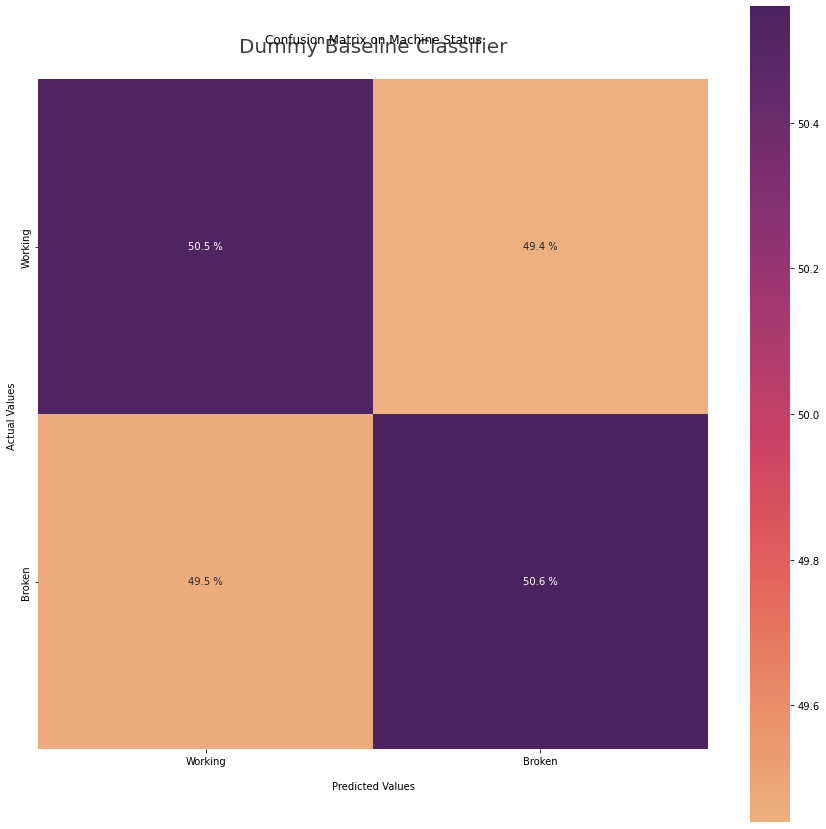

In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, RocCurveDisplay, classification_report
from sklearn.model_selection import ShuffleSplit

baseline = DummyClassifier(strategy='stratified')
baseline.fit(X_train, y_train)
print(baseline.score(X_test, y_test))
print(classification_report(y_test, baseline.predict(X_test)))

y_pred = baseline.predict(X_test)



#format data for data visualisation
cm = confusion_matrix(y_test, y_pred)
cm_percent = np.around(cm/cm.sum(axis=0) * 100,2)

#plot confusion matrix
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm_percent, annot=True,fmt = '.1f', square=1,cmap='flare')
ax.set_title('Confusion Matrix on Machine Status\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
for t in ax.texts: t.set_text(t.get_text() + " %")

## tick labels
ax.xaxis.set_ticklabels(['Working','Broken'])
ax.yaxis.set_ticklabels(['Working','Broken'])
plt.text(x=0.6 , y=-0.08, s='Dummy Baseline Classifier', fontsize=20, alpha=0.75)
sns.set(font_scale = 2)
plt.show()


### (C1) K-Nearest Neighbours (KNN)

> Why KNN?

KNN is most useful when labeled data is too expensive or impossible to obtain, and it can achieve high accuracy in a wide variety of prediction-type problems.

KNN is a simple algorithm, based on the local minimum of the target function which is used to learn an unknown function of desired precision and accuracy.


<Figure size 432x288 with 0 Axes>

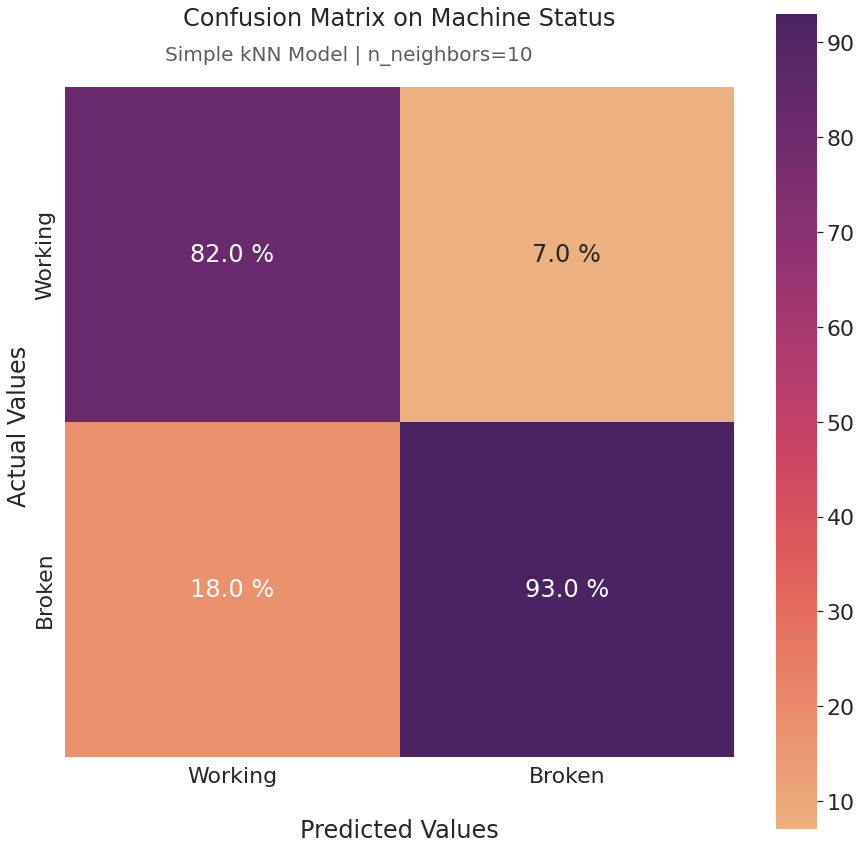

              precision    recall  f1-score   support

     Working       0.82      0.94      0.88      3816
      Broken       0.93      0.79      0.86      3816

    accuracy                           0.87      7632
   macro avg       0.88      0.87      0.87      7632
weighted avg       0.88      0.87      0.87      7632



In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, RocCurveDisplay, classification_report
from sklearn.metrics import plot_confusion_matrix
import math
import seaborn as sns
from sklearn.model_selection import ShuffleSplit

plt.clf()
#train and fit model
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


#format data for data visualisation
cm = confusion_matrix(y_test, y_pred)
cm_percent = np.around(cm/cm.sum(axis=0) * 100,2)

#plot confusion matrix
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm_percent, annot=True,fmt = '.1f', square=1,cmap='flare')
ax.set_title('Confusion Matrix on Machine Status\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
for t in ax.texts: t.set_text(t.get_text() + " %")

## tick labels
ax.xaxis.set_ticklabels(['Working','Broken'])
ax.yaxis.set_ticklabels(['Working','Broken'])
plt.text(x=0.3 , y=-0.08, s='Simple kNN Model | n_neighbors=10', fontsize=20, alpha=0.75)
sns.set(font_scale = 2)
plt.show()


## Display the visualization of the Confusion Matrix.


pred_prob = knn.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

#add results to cache to display later
auc_dict['kNN'] = [fpr,tpr,roc_auc]
report = classification_report(y_test,y_pred, target_names=['Working','Broken'], output_dict=True)
f1_dict['kNN'] = [report['weighted avg']['f1-score'],report['weighted avg']['recall']]

# Display Classification Report
print(classification_report(y_test,y_pred, target_names=['Working','Broken']))

#retry model with cross validation
plot_x = cross_val_score(knn, X_test, y_test, cv=5, scoring='f1_macro')
plot_y = np.arange(1,6)
cross_dict['kNN'] = [plot_x,plot_y]

#retry model with shufflesplit
n_samples = X_test.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
plot_x = cross_val_score(knn, X_test, y_test, cv=cv)
plot_y = np.arange(1,6)
shuffle_dict['kNN'] = [plot_x,plot_y]

from sklearn.metrics import precision_recall_curve

#
y_pred_prob = knn.predict_proba(X_test)[:,1]
#
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
#
pr_dict['kNN'] = [recall,precision]


#### (C1B) Model Analysis
> From first glance, we can see that the KNN model is effective at detective True Positive Values for *Working* Machines.
>
> However, we can see that it is not as effective at detecting True Positive Values for *Broken* Machines.
>
<br>

Additionally, Since kNN is non-parametric, and it doesn't make any assumptions, this means all the attributes will be treated as equally important for the results.

This is simply not always the case and if you want to navigate around noise in a noisy data kNN may not be suitable for this dataset.

On top of that, kNN can't handle data with missing values unless you apply a process called imputation.

This means missing values in your data will be filled with certain numerical values such as averages, ones, zeros etc.

This can be a tedious extra task, and it can also introduce wrong bias to the data.

<br>

### (C2) Support Vector Machine (SVM)
>Why SVM?

It can solve linear and non-linear problems and work well for many practical problems.

The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes.

In [16]:
from sklearn import svm
import pandas as pd
import numpy as np
clf = svm.SVC(kernel='rbf',probability=True).fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

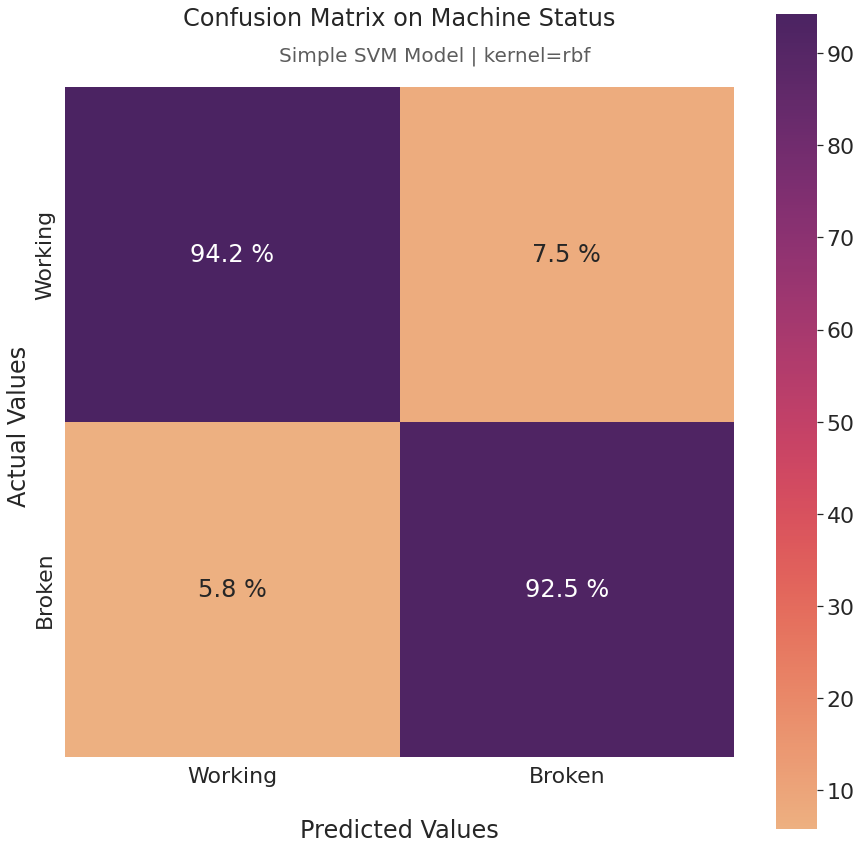

              precision    recall  f1-score   support

     Working       0.94      0.92      0.93      3816
      Broken       0.93      0.94      0.93      3816

    accuracy                           0.93      7632
   macro avg       0.93      0.93      0.93      7632
weighted avg       0.93      0.93      0.93      7632

0.9336939760325325


In [17]:

#format data for data visualisation
cm_percent = np.around(cm/cm.sum(axis=0) * 100,2)

#plot confusion matrix
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm_percent, annot=True,fmt = '.1f', square=1,cmap='flare')
ax.set_title('Confusion Matrix on Machine Status\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
for t in ax.texts: t.set_text(t.get_text() + " %")

## tick labels
ax.xaxis.set_ticklabels(['Working','Broken'])
ax.yaxis.set_ticklabels(['Working','Broken'])
plt.text(x=0.64 , y=-0.08, s='Simple SVM Model | kernel=rbf', fontsize=20, alpha=0.75)
sns.set(font_scale = 2)
plt.show()
## Display the visualization of the Confusion Matrix and ROC-AUC Curve.


pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

auc_dict['SVM'] = [fpr,tpr,roc_auc]
report = classification_report(y_test,y_pred, target_names=['Working','Broken'], output_dict=True)
f1_dict['SVM'] = [report['weighted avg']['f1-score'],report['weighted avg']['recall']]

# Display Classification Report

print(classification_report(y_test,y_pred, target_names=['Working','Broken']))
print(report['weighted avg']['f1-score'])

#retry model with cross validation
plot_x = cross_val_score(clf, X_test, y_test, cv=5, scoring='f1_macro')
plot_y = np.arange(1,6)
cross_dict['SVM'] = [plot_x,plot_y]

#retry model with shufflesplit
n_samples = X_test.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
plot_x = cross_val_score(clf, X_test, y_test, cv=cv)
plot_y = np.arange(1,6)
shuffle_dict['SVM'] = [plot_x,plot_y]

from sklearn.metrics import precision_recall_curve

#
y_pred_prob = clf.predict_proba(X_test)[:,1]
#
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
#
pr_dict['SVM'] = [recall,precision]

#### (C2B) Model Analysis
> From first glance, we can see that the SVM model is effective at detective both True Positive Values for *Working* Machines and detecting True Positive Values for *Broken* Machines.
>
<br>

When data has high dimension (think 1000+ features) a Support Vector Machine with the right settings (right kernel choice etc.) can be the way to go and produce really accurate results. However, since our dataset only has 10-11 features, it could lead to overfitting of data.

On top of that, Support Vector Machines don't have a scalable nature, and they don't work that well with mid-size or large datasets. Since our dataset only has 11 features but upwards of 40 thousand rows, this results in it being inefficient and ineffective at dealing with our scale of dataset.

<br>

Hence even though our F1-Score is 0.91-0.92, the scalability and computationally expensive nature of SVM does not lend itself well to hyper parameter tuning for this task.

### (C3) Logistic Regression

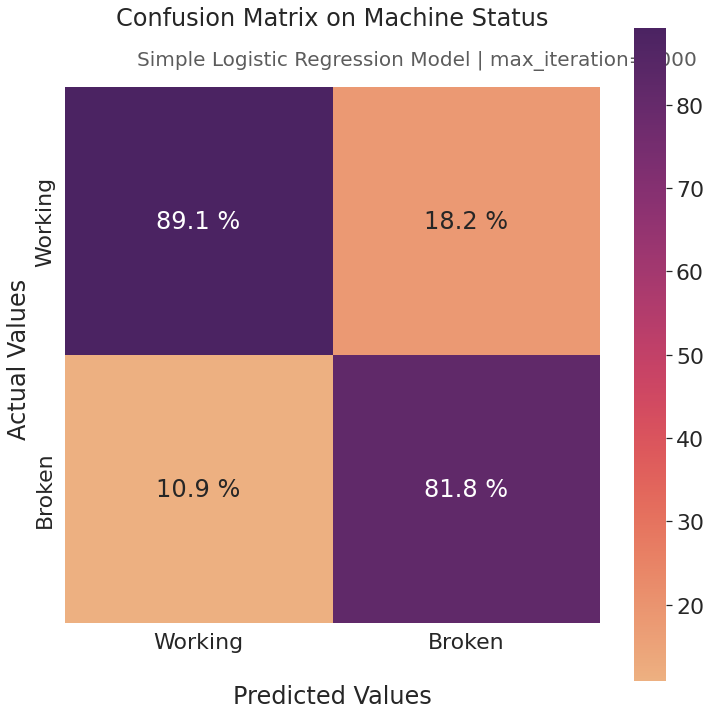

              precision    recall  f1-score   support

     Working       0.89      0.80      0.84      3816
      Broken       0.82      0.90      0.86      3816

    accuracy                           0.85      7632
   macro avg       0.85      0.85      0.85      7632
weighted avg       0.85      0.85      0.85      7632



In [18]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=4,max_iter=1000).fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

#format data for data visualisation
cm_percent = np.around(cm/cm.sum(axis=0) * 100,2)

#plot confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cm_percent, annot=True,fmt = '.1f', square=1,cmap='flare')
ax.set_title('Confusion Matrix on Machine Status\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
for t in ax.texts: t.set_text(t.get_text() + " %")

## tick labels
ax.xaxis.set_ticklabels(['Working','Broken'])
ax.yaxis.set_ticklabels(['Working','Broken'])
plt.text(x=0.27 , y=-0.08, s='Simple Logistic Regression Model | max_iteration=1000', fontsize=20, alpha=0.75)
sns.set(font_scale = 2)

## Display the visualization of the Confusion Matrix and ROC-AUC Curve.
plt.show()

pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)


plt.show()

auc_dict['Log-Reg'] = [fpr,tpr,roc_auc]
report = classification_report(y_test,y_pred, target_names=['Working','Broken'], output_dict=True)
f1_dict['Log-Reg'] =[report['weighted avg']['f1-score'],report['weighted avg']['recall']]
# Display Classification Report
print(classification_report(y_test,y_pred, target_names=['Working','Broken']))

#retry model with cross validation
plot_x = cross_val_score(clf, X_test, y_test, cv=5, scoring='f1_macro')
plot_y = np.arange(1,6)
cross_dict['Log-Reg'] = [plot_x,plot_y]

#retry model with shufflesplit
n_samples = X_test.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
plot_x = cross_val_score(clf, X_test, y_test, cv=cv)
plot_y = np.arange(1,6)
shuffle_dict['Log-Reg'] = [plot_x,plot_y]

from sklearn.metrics import precision_recall_curve

#
y_pred_prob = clf.predict_proba(X_test)[:,1]
#
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
#
pr_dict['Log-Reg'] = [recall,precision]


#### (C3B) Model Analysis
>  From first glance, we can see that the Log-Reg model is NOT effective at detective neither True Positive Values for *Working* Machines nor detecting True Positive Values for *Broken* Machines.
>
<br>

Since Logistic Regression inherently runs on a linear model, this means even more restriction when it comes to implementing logistic regression, as our dataset is *non-linear*.

Additionally, Log-Reg is similar to kNN in such a way that Log-Reg can’t handle data with missing values unless you apply a process called imputation.

This means missing values in your data will be filled with certain numerical values such as averages, ones, zeros etc.

This can be a tedious extra task, and it can also introduce wrong bias to the data.
<br>

Thus, our F1-Score ends up being similar to that of SVM, at around 0.86, which is also terrible.

### (C4) Gradient Boosting

Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting.

It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees.

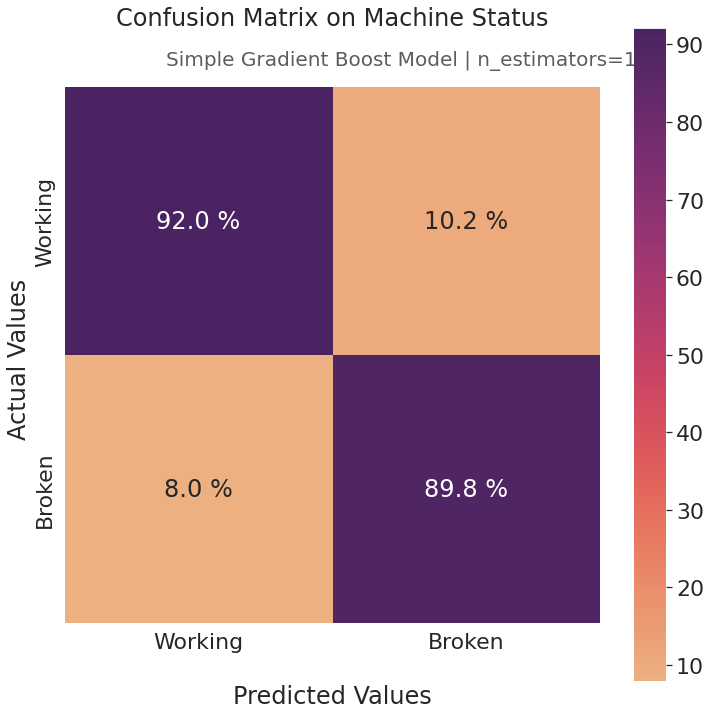

              precision    recall  f1-score   support

     Working       0.92      0.90      0.91      3816
      Broken       0.90      0.92      0.91      3816

    accuracy                           0.91      7632
   macro avg       0.91      0.91      0.91      7632
weighted avg       0.91      0.91      0.91      7632



In [19]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=42,max_features='auto',max_depth=1).fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)


#format data for data visualisation
cm_percent = np.around(cm/cm.sum(axis=0) * 100,2)

#plot confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cm_percent, annot=True,fmt = '.1f', square=1,cmap='flare')
ax.set_title('Confusion Matrix on Machine Status\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
for t in ax.texts: t.set_text(t.get_text() + " %")

## tick labels
ax.xaxis.set_ticklabels(['Working','Broken'])
ax.yaxis.set_ticklabels(['Working','Broken'])
plt.text(x=0.38 , y=-0.08, s='Simple Gradient Boost Model | n_estimators=100', fontsize=20, alpha=0.75)
sns.set(font_scale = 2)

## Display the visualization of the Confusion Matrix and ROC-AUC Curve.
plt.show()
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)


plt.show()

auc_dict['Gradient Boosting'] = [fpr,tpr,roc_auc]
report = classification_report(y_test,y_pred, target_names=['Working','Broken'], output_dict=True)
f1_dict['Gradient Boosting'] = [report['weighted avg']['f1-score'],report['weighted avg']['recall']]

# Display Classification Report
print(classification_report(y_test,y_pred, target_names=['Working','Broken']))

#retry model with cross validation
plot_x = cross_val_score(clf, X_test, y_test, cv=5, scoring='f1_macro')
plot_y = np.arange(1,6)
cross_dict['Gradient Boosting'] = [plot_x,plot_y]

#retry model with shufflesplit
n_samples = X_test.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
plot_x = cross_val_score(clf, X_test, y_test, cv=cv)
plot_y = np.arange(1,6)
shuffle_dict['Gradient Boosting'] = [plot_x,plot_y]

#precision recall curve
from sklearn.metrics import precision_recall_curve
y_pred_prob = clf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_dict['Gradient Boosting'] = [recall,precision]



#### (D4B) Model Analysis
> From first glance, we can see that the Gradient Boost model is decently effective at detective True Positive Values for *Working* Machines.
>
> Additionally, we can see that it is also decently effective at detecting True Positive Values for *Broken* Machines.
>
> This suggests that Gradient Boosting is able to consistently identify with decent accuracy True Positives and True Negatives.


<br>

With an F1-Score of 0.89, it is a strong candidate to proceed to further Model Analysis.

Additionally, Gradient Boost Models offer lots of flexibility - can optimize on different loss functions and provides several hyperparameter tuning options that make the function fit very flexible.

### (C5) AdaBoost

> Why use AdaBoost?

AdaBoost can be used to boost the performance of any machine learning algorithm. It is best used with weak learners. These are models that achieve accuracy just above random chance on a classification problem.

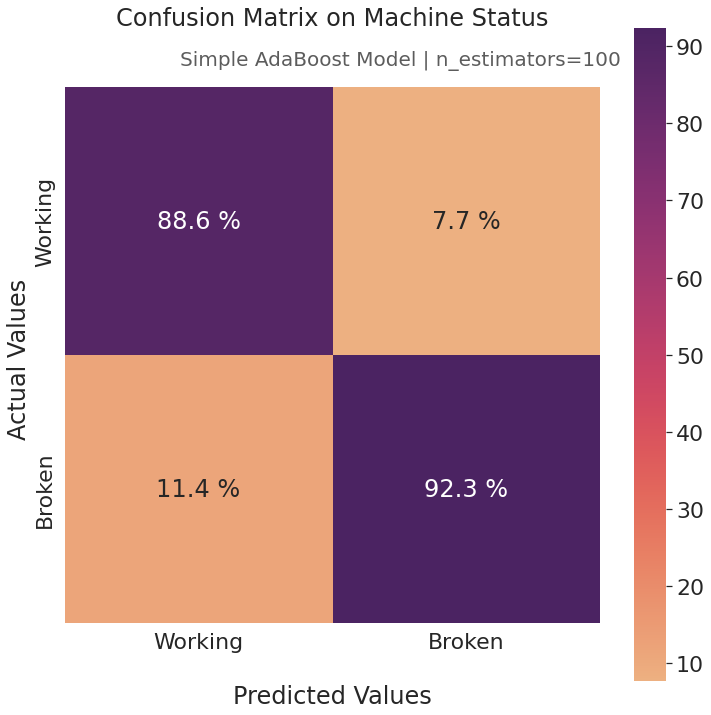

              precision    recall  f1-score   support

     Working       0.89      0.93      0.91      3816
      Broken       0.92      0.88      0.90      3816

    accuracy                           0.90      7632
   macro avg       0.90      0.90      0.90      7632
weighted avg       0.90      0.90      0.90      7632



In [20]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

#format data for data visualisation
cm_percent = np.around(cm/cm.sum(axis=0) * 100,2)

#plot confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cm_percent, annot=True,fmt = '.1f', square=1,cmap='flare')
ax.set_title('Confusion Matrix on Machine Status\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
for t in ax.texts: t.set_text(t.get_text() + " %")

## tick labels
ax.xaxis.set_ticklabels(['Working','Broken'])
ax.yaxis.set_ticklabels(['Working','Broken'])
plt.text(x=0.43 , y=-0.08, s='Simple AdaBoost Model | n_estimators=100', fontsize=20, alpha=0.75)
sns.set(font_scale = 2)

## Display the visualization of the Confusion Matrix and ROC-AUC Curve.
plt.show()
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)


plt.show()

auc_dict['AdaBoost'] = [fpr,tpr,roc_auc]
report = classification_report(y_test,y_pred, target_names=['Working','Broken'], output_dict=True)
f1_dict['AdaBoost'] = [report['weighted avg']['f1-score'],report['weighted avg']['recall']]
# Display Classification Report
print(classification_report(y_test,y_pred, target_names=['Working','Broken']))

#retry model with cross validation
plot_x = cross_val_score(clf, X_test, y_test, cv=5, scoring='f1_macro')
plot_y = np.arange(1,6)
cross_dict['AdaBoost'] = [plot_x,plot_y]
#retry model with shufflesplit
n_samples = X_test.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
plot_x = cross_val_score(clf, X_test, y_test, cv=cv)
plot_y = np.arange(1,6)
shuffle_dict['AdaBoost'] = [plot_x,plot_y]

from sklearn.metrics import precision_recall_curve

#
y_pred_prob = clf.predict_proba(X_test)[:,1]
#
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
#
pr_dict['AdaBoost'] = [recall,precision]



#### (D5B) Model Analysis
> From first glance, we can see that the Gradient Boost model is decently effective at detective True Positive Values for *Working* Machines.
>
> Additionally, we can see that it is also decently effective at detecting True Positive Values for *Broken* Machines.
>
> This suggests that Gradient Boosting is able to consistently identify with decent accuracy True Positives and True Negatives.

> Additionally, we can observe that for Working Machines, recall is greater than precision, meaning that the model returns many results, but most of its predicted labels are incorrect when compared to the <u>training labels</u>.

> The opposite is true for Broken Machines, where we can see that the precision is greater than the recall, meaning that the model returns very few results, but most of its predicted labels are correct when compared to the <u>training labels</u>.
<br>

With an F1-Score of 0.89, it is a strong candidate to proceed to further Model Analysis.

Additionally, AdaBoost Models offer lots of flexibility as the accuracy of weak classifiers can be improved by using Adaboost.

However, Adaboost needs a quality dataset. Noisy data and outliers have to be avoided before adopting an Adaboost algorithm, which might be an area of concern.

### (C6) Conclusion

We can take a look at the AOC Curves, F1-Scores and Recall Scores for each Model to determine which top 2 models to choose for further Model Selection & Analysis.

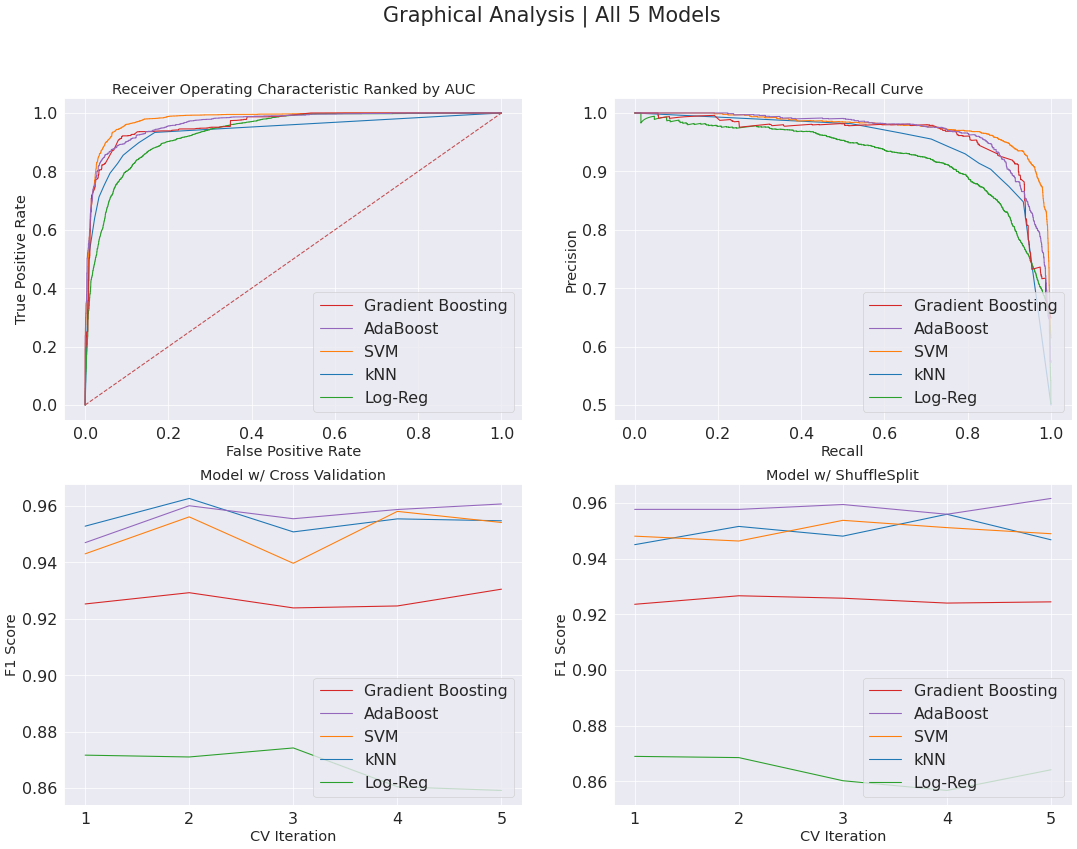

In [21]:
colors = sns.color_palette("tab10")
plt.figure(figsize=(25,18),dpi=52)

#plot comparative AUC ROC Graph
plt.subplot(2, 2, 1)
i=0
for key in auc_dict.keys():
    fpr = auc_dict[key][0]
    tpr = auc_dict[key][1]
    roc_auc = auc_dict[key][2]
    plt.plot(fpr, tpr, label = key,color=colors[i])
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic Ranked by AUC',fontsize=20)

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [3,4,1,0,2]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc = 'lower right')

#plot comparative ShuffleSplit Graph
plt.subplot(2, 2, 4)
i=0
for key in shuffle_dict.keys():

    plot_x = shuffle_dict[key][1]
    plot_y = shuffle_dict[key][0]
    plt.plot(plot_x, plot_y, label = key,color=colors[i])
    i+=1

plt.ylabel('F1 Score',fontsize=20)
plt.xlabel('CV Iteration',fontsize=20)
plt.title('Model w/ ShuffleSplit',fontsize=20)
plt.xticks([1,2,3,4,5])
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [3,4,1,0,2]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc = 'lower right')

#plot comparative Cross Validation Graph
plt.subplot(2, 2, 3)
i=0
for key in cross_dict.keys():

    plot_x = cross_dict[key][1]
    plot_y = cross_dict[key][0]
    plt.plot(plot_x, plot_y, label = key,color=colors[i])
    i+=1

plt.ylabel('F1 Score',fontsize=20)
plt.xlabel('CV Iteration',fontsize=20)
plt.title('Model w/ Cross Validation',fontsize=20)
plt.xticks([1,2,3,4,5])
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [3,4,1,0,2]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc = 'lower right')

#plot comparative precision recall curves
plt.subplot(2, 2, 2)
i=0
for key in pr_dict.keys():

    plot_x = pr_dict[key][0]
    plot_y = pr_dict[key][1]
    plt.plot(plot_x, plot_y, label = key,color=colors[i])
    i+=1

plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title('Precision-Recall Curve',fontsize=20)

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [3,4,1,0,2]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc = 'lower right')


plt.suptitle('Graphical Analysis | All 5 Models')
plt.show()

> ## ROC AUC Curve
>    As we can see, Gradient Boosting and AdaBoost have the 2 highest area below curve
>
>    Additionally, we can see that the Logistic Regression has a greater rate of error, since at any given point, the ratio of True Positive to False positive is a lot lower than the other 4 models. This suggests that the Logistic Regression Model is more prone to throwing False Positive Errors

> ## F1 Score-Recall Score Curve
>    As we can see, Gradient Boosting and AdaBoost have the 2 highest F1 Score-Recall Score values. This means that it's ability to find all the positive samples in the dataset in much better than the rest.
>
>    Additionally, we can see that the Logistic Regression has a greater rate of error, since at any given point, the ratio of F1 Score to Recall Score is a lot lower than the other 4 models. This suggests that the Logistic Regression Model is more prone to being less reliable.

> ## Model w/ Cross Validation
>    For this graph, we can see the different F1 Scores for each model after cross validation. As we can see, Gradient Boosting and AdaBoost have the 2 highest F1 Scores, but the other 2 Models are also close behind.
>
>    Additionally, we can see that the Logistic Regression is just terrible, since for any given CV Value, its F1 Score does not exceed 0.88, whereas the other models' F1 Scores are all above 0.94. This suggests that the Logistic Regression Model is ineffective even after model cross validation

> ## Precision-Recall Curve
>    A Precision-Recall curve shows the relationship between positive predictive value and sensitivity for every possible cut-of. As we can see, Gradient Boosting and AdaBoost have the 2 highest area below curve
>
>    Additionally, we can see that the Logistic Regression has a greater rate of error, since at any given point, the ratio of True Positive to False positive is a lot lower than the other 4 models. This suggests that the Logistic Regression Model is more prone to throwing False Positive Errors



Since Gradient Boosting and AdaBoost ranked in the top 2, we will proceed with Gradient Boosting and AdaBoost for Further Hyperparameter Tuning!

## (D) ML Model Selection & Analysis

### (D1) AdaBoost
#### (D1A) Hyperparameter Tuning
<br>

[References](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Parameters
1. `n_estimators`
2. `learning_rate`

In [22]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

#define model
model = AdaBoostClassifier()

# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500,1000]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['algorithm'] = ['SAMME', 'SAMME.R']
grid['random_state'] = [42]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

# define randomizedsearch
grid_search = RandomizedSearchCV(model,grid, n_jobs=-1, cv=cv, scoring='f1')

# Start GridSearch
result = grid_search.fit(X_train, y_train)


# be sure to change the code a bit
# summarize the best score and configuration
print("Best: %f using %s" % (result.best_score_, result.best_params_))

# summarize all scores that were evaluated
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.933346 using {'random_state': 42, 'n_estimators': 50, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
0.736780 (0.007846) with: {'random_state': 42, 'n_estimators': 50, 'learning_rate': 0.0001, 'algorithm': 'SAMME.R'}
0.736780 (0.007846) with: {'random_state': 42, 'n_estimators': 50, 'learning_rate': 0.0001, 'algorithm': 'SAMME'}
0.926312 (0.005406) with: {'random_state': 42, 'n_estimators': 100, 'learning_rate': 1.0, 'algorithm': 'SAMME'}
0.933346 (0.004755) with: {'random_state': 42, 'n_estimators': 50, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
0.736789 (0.007927) with: {'random_state': 42, 'n_estimators': 10, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'}
0.785566 (0.007769) with: {'random_state': 42, 'n_estimators': 100, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'}
0.736780 (0.007846) with: {'random_state': 42, 'n_estimators': 10, 'learning_rate': 0.001, 'algorithm': 'SAMME'}
0.736780 (0.007846) with: {'random_state': 42, 'n_estimators': 10, 'learning_rate': 0.0001, 'al

#### (D1B) Finalised Model


### (D2) Gradient Boosting

#### (D2A) Hyperparameter Tuning
<br>

[References](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

1. `random_state` (keep constant not GridSearch)
2. `learning_rate`
3. `n_estimators`
4. `criterion`
5. `min_samples_split`
6. `min_samples_leaf`
7. `max_depth`


In [23]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

#define model
model = GradientBoostingClassifier()

# define the grid of values to search
grid = dict()
grid['min_samples_split'] = [400,500,600,1000]
grid['learning_rate'] = [0.1,0.2,0.3]
grid['n_estimators'] = [100,200,300]
grid['min_samples_leaf'] = [10,50,500,1000]
grid['max_depth'] = [5,6,7,8,10]
grid['criterion'] = ['friedman_mse', 'squared_error']
grid['max_features'] = ['auto', 'sqrt', 'log2']
grid['random_state'] = [42]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

# define GridSearch
grid_search = RandomizedSearchCV(model, grid, n_jobs=-1, cv=cv, scoring='f1')

# Start GridSearch
result = grid_search.fit(X_train, y_train)


# be sure to change the code a bit
# summarize the best score and configuration
print("Best: %f using %s" % (result.best_score_, result.best_params_))

# summarize all scores that were evaluated
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.997506 using {'random_state': 42, 'n_estimators': 300, 'min_samples_split': 500, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 8, 'learning_rate': 0.3, 'criterion': 'friedman_mse'}
0.985572 (0.002038) with: {'random_state': 42, 'n_estimators': 300, 'min_samples_split': 400, 'min_samples_leaf': 1000, 'max_features': 'auto', 'max_depth': 6, 'learning_rate': 0.1, 'criterion': 'squared_error'}
0.996616 (0.001170) with: {'random_state': 42, 'n_estimators': 200, 'min_samples_split': 1000, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 8, 'learning_rate': 0.2, 'criterion': 'friedman_mse'}
0.982090 (0.002527) with: {'random_state': 42, 'n_estimators': 100, 'min_samples_split': 600, 'min_samples_leaf': 50, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.1, 'criterion': 'squared_error'}
0.992685 (0.001612) with: {'random_state': 42, 'n_estimators': 100, 'min_samples_split': 500, 'min_samples_leaf': 500, 'max_features': 'auto', 'max_depth': 8, 'lear

### (D3) Finalised Model
 Our finalised model is Gradient Boosting, coming at 99.14% accuracy after hyperparameter tuning. Since our model is choosing from a very large pool of data to determine whether a machine is broken, precision and recall are useful in cases where classes aren't evenly distributed.

Therefore, I decided on using F1-Score during hyperparameter tuning to ensure that the model is operating on a system that prioritises both precision and recall.

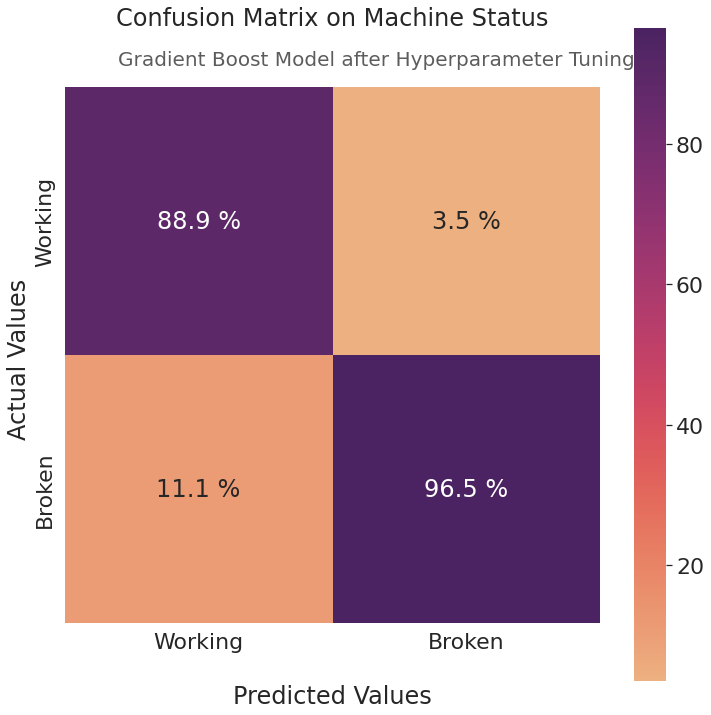

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=42, min_samples_split=600,min_samples_leaf=10,max_features='auto',max_depth=10).fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

#format data for data visualisation
cm_percent = np.around(cm/cm.sum(axis=0) * 100,2)

#plot confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cm_percent, annot=True,fmt = '.1f', square=1,cmap='flare')
ax.set_title('Confusion Matrix on Machine Status\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
for t in ax.texts: t.set_text(t.get_text() + " %")

## tick labels
ax.xaxis.set_ticklabels(['Working','Broken'])
ax.yaxis.set_ticklabels(['Working','Broken'])
plt.text(x=0.2 , y=-0.08, s='Gradient Boost Model after Hyperparameter Tuning', fontsize=20, alpha=0.75)
sns.set(font_scale = 2)
plt.show()

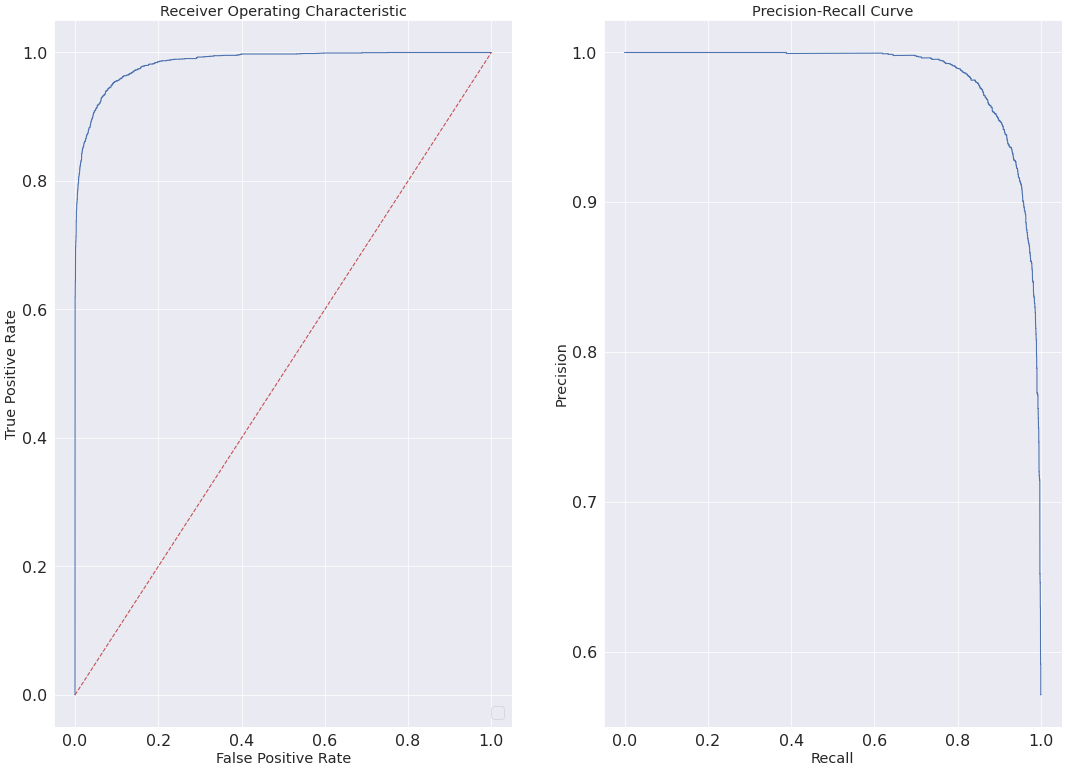

              precision    recall  f1-score   support

     Working       0.89      0.97      0.93      3816
      Broken       0.96      0.88      0.92      3816

    accuracy                           0.92      7632
   macro avg       0.93      0.92      0.92      7632
weighted avg       0.93      0.92      0.92      7632



In [25]:

## Display the visualization of the Confusion Matrix and ROC-AUC Curve.
plt.figure(figsize=(25,18),dpi=52)
plt.subplot(1, 2, 1)
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic',fontsize=20)


plt.subplot(1, 2, 2)
from sklearn.metrics import precision_recall_curve
y_pred_prob = clf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall,precision)
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title('Precision-Recall Curve',fontsize=20)
plt.show()

# Display Classification Report
report = classification_report(y_test,y_pred, target_names=['Working','Broken'], output_dict=True)
print(classification_report(y_test,y_pred, target_names=['Working','Broken']))




Feature: Quality | Score: 1.06%
Feature: Product Code | Score: 0.41%
Feature: Process T (C) | Score: 1.67%
Feature: Ambient T (C) | Score: 1.78%
Feature: T Difference Squared (C^2) | Score: 5.15%
Feature: Tool Lifespan (min) | Score: 22.68%
Feature: Tool Lifespan/Temp Increase^2 (min/C^2) | Score: 0.98%
Feature: Rotation Speed (rpm) | Score: 32.00%
Feature: Torque (Nm) | Score: 7.38%
Feature: Horsepower (HP) | Score: 26.90%


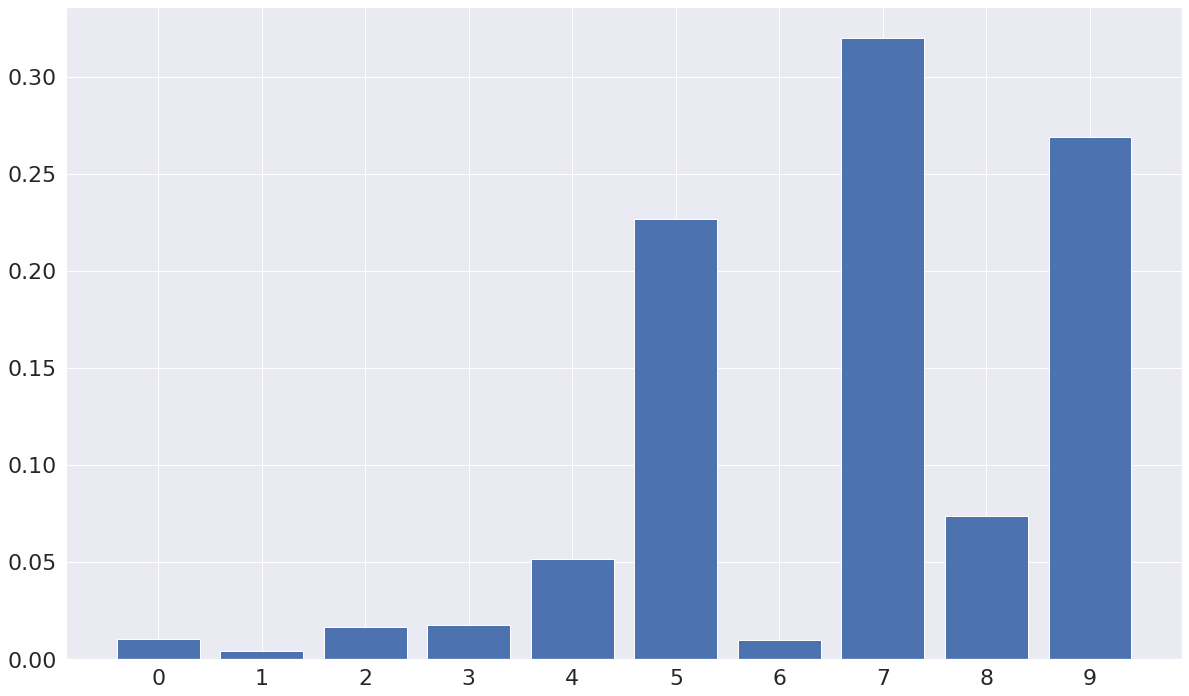

In [26]:
# get importance
importance = clf.feature_importances_

feature_list = [
    'Quality',
    'Product Code',
    'Process T (C)',
    'Ambient T (C)',
    'T Difference Squared (C^2)',
    'Tool Lifespan (min)',
    'Tool Lifespan/Temp Increase^2 (min/C^2)',
    'Rotation Speed (rpm)',
    'Torque (Nm)',
    'Horsepower (HP)'

]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s | Score: %.2f%%' % (feature_list[i],v*100))



# plot feature importance
f, ax = plt.subplots(figsize=(20, 12))
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.show()

## (E) Questions & Answers

<br>

### (1) How is your prediction task defined?
> My prediction task is defined by: Using the given features, how accurate is my model able to predict which
> machine/component will possibly fail before it actually fails.
<br>

### (1.5) What is the meaning of the output variable?
> The meaning of the output variable indicates whether the Machine Status; whether the machine failed or not, 1 means
> failure, 0 means normal.
<br>

### (2) How do you represent your data as features?
>In machine learning, a feature is an individual measurable property. In this case, I can represent the column
variables as features in the model, such as ` Ambient T (C)` and ` Rotation Speed (rpm)`
<br>

### (3) Did you process the features in any way?
> I added 3 new features:
 > 1. `T Difference Squared (C^2)`
  > Temperature Difference Squared highlights *greater differences in* temperature change, which will give the model more impactful data to work with.
  > Thus, we can study the relationship between the Temperature Difference Squared of the machine's processes versus its reliability.

 > 2. `Tool Lifespan/Temp Increase^2 (min/C^2)`
  > Tool Lifespan per Increase in Temperature Squared takes the aforementioned feature and **combines** it with Tool Lifespan to calculate
  > the *impact of temperature increase on the lifespan of tools*.
  > Thus, we can study the relationship between the Tool Lifespan per Increase in Temperature Squared of the machine in conjunction with its reliability.

 > 3. `Horsepower (HP)`
  > Horsepower is calculated using: $\frac{{\sf RPM} \times {\sf Torque}{\nbsp}(Nm)}{5252} $
  > Horsepower is an important condition for the manufacturer to take into account, as it directly translates to the performance of the machine.
  > Thus, we can study the relationship between the Horsepower of the machine versus its reliability.

### (4) How did you select which learning algorithms to use?
> For the initial stages of model exploration, I selected the most popular classification models that I could find on Google. After running them on the cleaned data with default settings, I decided to pick the top 2 models that had the highest F1 Score. This ended up being Adaptive Boost (AdaBoost) and Gradient Boosting
<br>

### (5) Did you try to tune the hyperparameters of the learning algorithm, and in that case how?
> Yes. I decided to choose the top 2 models to proceed with hyperparameter tuning. Initially, I tried to use GridSearchCV, but it took too much time, hence I proceeded to use RandomizedSearchCV. I took the parameters of each model and input various values for the Random Search to find the best parameters.
<br>

### (6) How do you evaluate the quality of your system?
> I evaluated the quality of my system by checking several factors.
> 1. Accuracy
> 2. F1 Score
> 3. Precision Score
> 4. Area under ROC Curve
> 5. Confusion Matrix

Accuracy, F1 score and Precision Score give a good representation to how accurate the model is. Confusion Matrix is used to calculate recall and precision, and Area under ROC Curve is used to calculate the performance of the model at all its threshold values.

### (7) How well does your system compare to a stupid baseline?
> By using a baseline, we can put a lower bound on our metrics. Baselines help quantify that and tell us how much better we are than predicting random or the most common values. (German, C M, 2021) We can then evaluate the performance of each model in comparison with its baseline.
>
>
> As compared to a stupid baseline, where the F1-Score is 0.51, my model comes in at 0.91. This means that my model is much more accurate at a recall and precision level.

### (8) Can you say anything about the errors that the system makes?


### (9) Is it possible to say something about which features the model considers important?
> When we analyse the feature importance of the model, we can see that the top 3 features accounting for upwards of 80% of the weight of the model's significance are:
   > 1.  _Rotation Speed_ (34.51%)
        This can be due to the fact that since the machines are working in a factory environment, the rotation speed of the machine is directly correlated to the wear and tear of the machine. If not supplied with enough lubricant, and the rotation speed gets too high, this can cause friction welding and damage to the machine. Such damage may this contribute to the failure of the machine

   > 2.  _Horsepower_ (26.66%)
       As horsepower is a measure of speed and power output (Schneider, Blossfeld and Balnaves, 1988), it may damage and cause wear to the pistons of the machine that are responsible for producing the necessary required power output. This may result in reduced power output that may not match up to the specifications required for the machine to run, and therefore increase the risk of the machine failing.

   > 3.  _Tool Lifespan_ (21.01%)
       Tool Lifespan is the tool wear time estimated for the machine. As expected, the shorter the tool lifespan, the faster the machine will fail, as it will be operating on almost or already broken tools and machinery.


References
- https://datascience.stackexchange.com/questions/90175/comparing-ml-models-to-baselines
- https://www.jstor.org/stable/44547452
- Schneider, E.W., Blossfeld, D.H. and Balnaves, M.A. (1988). Effect of Speed and Power Output on Piston Ring Wear in a Diesel Engine. SAE Transactions, [online] 97, pp.1257–1267. Available at: https://www.jstor.org/stable/44547452 [Accessed 9 Jun. 2022].